In [2]:
%pylab inline
from IPython.display import Image
import os.path as op
import nibabel as nb
data_dir = '/data/ds000114/'

def plot_nii(in_file):
    nb.load(in_file).orthoview()

Populating the interactive namespace from numpy and matplotlib


# Task 1: Run both T1s through a single BET interface

Hint: use `nipype.pipeline.engine.MapNode`

In [5]:
from nipype import MapNode
from nipype.interfaces import fsl

bet_node = MapNode(fsl.BET(), name='bet', iterfield=['in_file'])
bet_node.inputs.in_file = [
    op.join(data_dir, 'sub-01', 'ses-test', 'anat', 'sub-01_ses-test_T1w.nii.gz'),
    op.join(data_dir, 'sub-02', 'ses-test', 'anat', 'sub-02_ses-test_T1w.nii.gz'),
]

In [6]:
res = bet_node.run()
print(res.outputs.out_file)

180124-09:54:13,275 workflow INFO:
	 Executing node bet in dir: /tmp/tmpo6g90p70/bet
180124-09:54:13,282 workflow INFO:
	 Executing node _bet0 in dir: /tmp/tmpo6g90p70/bet/mapflow/_bet0
180124-09:54:13,287 workflow INFO:
	 Running node "_bet0" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz /tmp/tmpo6g90p70/bet/mapflow/_bet0/sub-01_ses-test_T1w_brain.nii.gz.
180124-09:54:17,549 workflow INFO:
	 Executing node _bet1 in dir: /tmp/tmpo6g90p70/bet/mapflow/_bet1
180124-09:54:17,554 workflow INFO:
	 Running node "_bet1" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/ds000114/sub-02/ses-test/anat/sub-02_ses-test_T1w.nii.gz /tmp/tmpo6g90p70/bet/mapflow/_bet1/sub-02_ses-test_T1w_brain.nii.gz.
['/tmp/tmpo6g90p70/bet/mapflow/_bet0/sub-01_ses-test_T1w_brain.nii.gz', '/tmp/tmpo6g90p70/bet/mapflow/_bet1/sub-02_ses-test_T1w_brain.nii.gz']


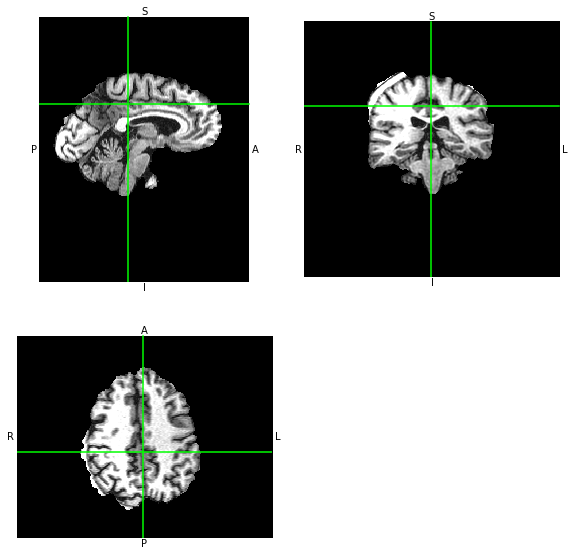

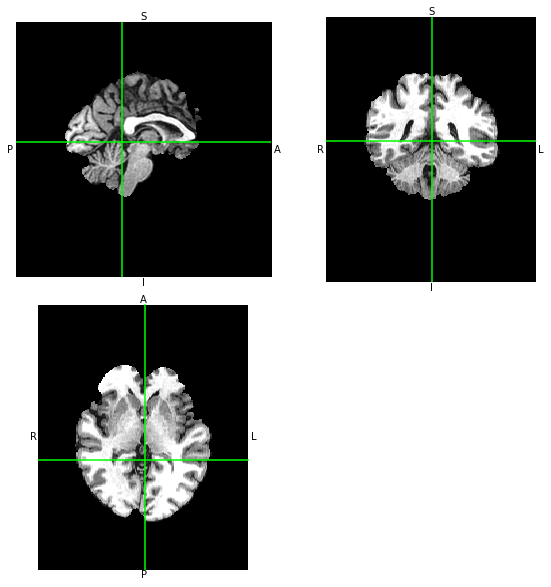

In [7]:
plot_nii(res.outputs.out_file[0])
plot_nii(res.outputs.out_file[1])

# Task 2: Run both subjects' functional through MCFLIRT
Hint: iterables + `MapNodes`

In [12]:
# Solution 1: only MapNode
import glob
mcflirt_node = MapNode(fsl.MCFLIRT(), name='mcflirt', iterfield=['in_file'])
mcflirt_node.base_dir = 'nipype_101'
mcflirt_node.inputs.in_file = glob.glob(op.join(data_dir, 'sub-0[1,2]', 'ses-test', 'func', '*fingerfootlips_bold.nii.gz'))
res = mcflirt_node.run()
res.outputs.out_file

180124-09:55:35,628 workflow INFO:
	 Executing node mcflirt in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt
180124-09:55:35,634 workflow INFO:
	 Executing node _mcflirt0 in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt/mapflow/_mcflirt0
180124-09:55:35,638 workflow INFO:
	 Running node "_mcflirt0" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz -out /home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt/mapflow/_mcflirt0/sub-01_ses-test_task-fingerfootlips_bold_mcf.nii.gz.
180124-09:56:14,14 workflow INFO:
	 Executing node _mcflirt1 in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt/mapflow/_mcflirt1
180124-09:56:14,19 workflow INFO:
	 Running node "_mcflirt1" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /data/

['/home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt/mapflow/_mcflirt0/sub-01_ses-test_task-fingerfootlips_bold_mcf.nii.gz',
 '/home/neuro/workshop/nipy_workshops/170327-nipype/nipype_101/mcflirt/mapflow/_mcflirt1/sub-02_ses-test_task-fingerfootlips_bold_mcf.nii.gz']

In [13]:
# Solution 2: iterables + MapNode
from nipype import Workflow, Node
from nipype.interfaces.utility import Function

def _get_bolds(subject_id, data_dir):
    import glob
    import os.path as op
    return glob.glob(op.join(data_dir, 'sub-%s' % subject_id, 'ses-test', 'func', '*fingerfootlips_bold.nii.gz'))

dg_node = Node(Function(input_names=['subject_id', 'data_dir'], output_names=['out_files'], function=_get_bolds),
               name='datagrabber')
mcflirt_node = MapNode(fsl.MCFLIRT(), name='mcflirt', iterfield=['in_file'])

wf = Workflow('task2')
wf.base_dir = 'workdir_task2'
wf.connect(dg_node, 'out_files', mcflirt_node, 'in_file')

dg_node.iterables = ('subject_id', ['01', '02'])
dg_node.inputs.data_dir = data_dir
wf.run()

180124-09:56:50,731 workflow INFO:
	 Workflow task2 settings: ['check', 'execution', 'logging']
180124-09:56:50,741 workflow INFO:
	 Running serially.
180124-09:56:50,742 workflow INFO:
	 Executing node task2.datagrabber in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/workdir_task2/task2/_subject_id_02/datagrabber
180124-09:56:50,747 workflow INFO:
	 Running node "datagrabber" ("nipype.interfaces.utility.wrappers.Function").
180124-09:56:50,754 workflow INFO:
	 Executing node task2.mcflirt in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/workdir_task2/task2/_subject_id_02/mcflirt
180124-09:56:50,759 workflow INFO:
	 Executing node _mcflirt0 in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/workdir_task2/task2/_subject_id_02/mcflirt/mapflow/_mcflirt0
180124-09:56:50,764 workflow INFO:
	 Running node "_mcflirt0" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /data/ds000114/sub-02/ses-test/func/sub-02_ses-test_tas

# Task 3: Get the number of subjects using bids
Hint: [notebook](https://github.com/nipy/workshops/blob/master/170327-nipype/notebooks/basic-bids/basic_data_input_bids.ipynb)

In [14]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout(data_dir)
print('Number of subjects is %d' % len(layout.get_subjects()))

Number of subjects is 10


# Task 4: Use a function node to get T1w + EPIs using bids


In [15]:
def get_info(subject_id, dataset_dir):
    from bids.grabbids import BIDSLayout
    layout = BIDSLayout(dataset_dir)
    t1w = layout.get(type='T1w', 
                     subject=subject_id, 
                     extensions=['nii', 'nii.gz'],
                     return_type='file')
    epi = [f.filename for f in layout.get(type='bold', subject=subject_id, extensions=['nii', 'nii.gz'])]
    return t1w, epi

In [16]:
# Test get_info:
print(get_info('01', data_dir))
print(get_info('0[12]', data_dir))

(['/data/ds000114/sub-01/ses-retest/anat/sub-01_ses-retest_T1w.nii.gz', '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz'], ['/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-covertverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-linebisection_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-overtverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-overtwordrepetition_bold.nii.gz', '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-covertverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz', '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-linebisection_bold.nii.gz', '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-overtverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-test/

In [17]:
node_bids = Node(Function(input_names=['subject_id', 'dataset_dir'], output_names=['t1w', 'epi'],
                          function=get_info), name='bids_ds')
node_bids.inputs.subject_id = '0[12]'
node_bids.inputs.dataset_dir = data_dir

# Test this node
res = node_bids.run()
print(res.outputs.t1w)
print(res.outputs.epi)

180124-09:58:07,70 workflow INFO:
	 Executing node bids_ds in dir: /tmp/tmpas6zqg4n/bids_ds
180124-09:58:07,75 workflow INFO:
	 Running node "bids_ds" ("nipype.interfaces.utility.wrappers.Function").
['/data/ds000114/sub-01/ses-retest/anat/sub-01_ses-retest_T1w.nii.gz', '/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz', '/data/ds000114/sub-02/ses-retest/anat/sub-02_ses-retest_T1w.nii.gz', '/data/ds000114/sub-02/ses-test/anat/sub-02_ses-test_T1w.nii.gz']
['/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-covertverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-fingerfootlips_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-linebisection_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-overtverbgeneration_bold.nii.gz', '/data/ds000114/sub-01/ses-retest/func/sub-01_ses-retest_task-overtwordrepetition_bold.nii.gz', '/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_tas

# Task 5: A workflow with an input node and aggregating all before.

In [18]:
# We will need this little function
def _flatten(inlist):
    return [el for l in inlist for el in l]

print(_flatten([[1, 2], [3], [4, 5]]))

[1, 2, 3, 4, 5]


In [19]:
def _vol_mean(in_file):
    import nibabel as nb
    import numpy as np
    nii = nb.load(in_file)
    
    data = nii.get_data()
    voxvol = np.prod(nii.header.get_zooms()[:3])
    volume = sum(data > 0) * voxvol
    
    mean = data[data > 0].mean()
    
    return volume, mean

180124-10:00:01,704 workflow INFO:
	 Generated workflow graph: nipypework/task_5/graph.dot.png (graph2use=hierarchical, simple_form=True).


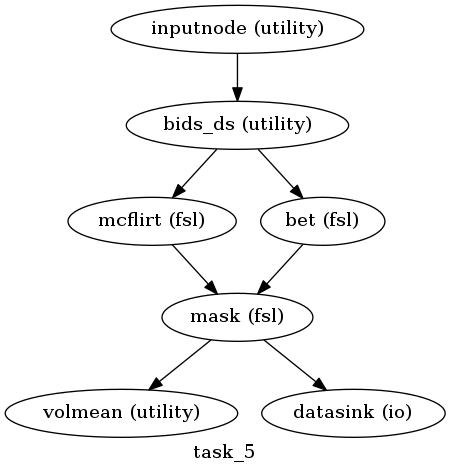

In [20]:
from nipype.interfaces.utility import IdentityInterface, Rename
from nipype.interfaces.io import DataSink

inputs_node = Node(IdentityInterface(fields=['subject_id']), name='inputnode')
bids_node = MapNode(Function(input_names=['subject_id', 'dataset_dir'], output_names=['t1w', 'epi'],
                             function=get_info),
                    name='bids_ds', 
                    iterfield=['subject_id']
)
bet_node = MapNode(fsl.BET(functional=True, mask=True), name='bet', iterfield=['in_file'])
mcflirt_node = MapNode(fsl.MCFLIRT(), name='mcflirt', iterfield=['in_file'])
applymsk_node = MapNode(fsl.ApplyMask(), name='mask', iterfield=['in_file', 'mask_file'])

volmean_node = MapNode(Function(input_names=['in_file'], output_names=['vol', 'mean'],
                       function=_vol_mean), name='volmean', iterfield=['in_file'])

ds_node = Node(DataSink(
    base_directory='/home/jovyan/work/workshops/170327-'
                   'nipype/notebooks/nipype_101_tasks/nipype_outputs'),
               name='datasink')

wf = Workflow('task_5')
wf.base_dir = 'nipypework'
wf.connect(inputs_node, 'subject_id', bids_node, 'subject_id')
wf.connect(bids_node, ('epi', _flatten), bet_node, 'in_file')
wf.connect(bids_node, ('epi', _flatten), mcflirt_node, 'in_file')
wf.connect(bet_node, 'mask_file', applymsk_node, 'mask_file')
wf.connect(mcflirt_node, 'out_file', applymsk_node, 'in_file')
wf.connect(applymsk_node, 'out_file', ds_node, 'epi')
wf.connect(applymsk_node, 'out_file', volmean_node, 'in_file')


Image(wf.write_graph())

In [21]:
# Time to run it
wf.inputs.inputnode.subject_id = ['01', '02']
wf.inputs.bids_ds.dataset_dir = data_dir
wf.run()

180124-10:00:02,361 workflow INFO:
	 Workflow task_5 settings: ['check', 'execution', 'logging']
180124-10:00:02,373 workflow INFO:
	 Running serially.
180124-10:00:02,375 workflow INFO:
	 Executing node task_5.bids_ds in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipypework/task_5/bids_ds
180124-10:00:02,382 workflow INFO:
	 Executing node _bids_ds0 in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipypework/task_5/bids_ds/mapflow/_bids_ds0
180124-10:00:02,386 workflow INFO:
	 Running node "_bids_ds0" ("nipype.interfaces.utility.wrappers.Function").
180124-10:00:02,445 workflow INFO:
	 Executing node _bids_ds1 in dir: /home/neuro/workshop/nipy_workshops/170327-nipype/nipypework/task_5/bids_ds/mapflow/_bids_ds1
180124-10:00:02,448 workflow INFO:
	 Running node "_bids_ds1" ("nipype.interfaces.utility.wrappers.Function").
180124-10:00:02,509 workflow ERROR:
	 Node mcflirt failed to run on host eb95bf0b07b9.
180124-10:00:02,511 workflow ERROR:
	 Saving crash info to /

180124-10:00:02,518 workflow INFO:
	 ***********************************
180124-10:00:02,520 workflow ERROR:
	 could not run node: task_5.mcflirt
180124-10:00:02,521 workflow INFO:
	 crashfile: /home/neuro/workshop/nipy_workshops/170327-nipype/crash-20180124-100002-neuro-mcflirt-88eb8d5c-85e1-4f4b-813a-b2b4790e703e.pklz
180124-10:00:02,522 workflow ERROR:
	 could not run node: task_5.bet
180124-10:00:02,523 workflow INFO:
	 crashfile: /home/neuro/workshop/nipy_workshops/170327-nipype/crash-20180124-100002-neuro-bet-8074c942-60ed-4acb-ba4f-c490e29b12b0.pklz
180124-10:00:02,524 workflow INFO:
	 ***********************************


RuntimeError: Workflow did not execute cleanly. Check log for details

In [22]:
!tree nipype_outputs/

nipype_outputs/ [error opening dir]

0 directories, 0 files


In [23]:
from nipype import JoinNode

In [24]:
from nipype.interfaces.utility import Merge

In [25]:
Merge??